In [36]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
import seaborn as sns
import scipy.io
import time
#from progress.bar import Bar

sns.set()
sns.set_style("white")

%matplotlib inline


## Simulation module implementation

### Description of the simulation module

At a high level, the simulation alternates between two states which is encoded by a variable `s`. In the setup, `u` and `v` are two neurons that mutually inhibit each other according to this dynamics:

$$ \tau\frac{du}{dt} = -u + \theta \ (W_{uI}I - W_{uv}v - sI_F)$$

Similarly for $v$,

$$ \tau\frac{dv}{dt} = -v + \theta \ (W_{vI}I - W_{vu}u + sI_F)$$

$y$ and $z$ are read-out neurons. $y$ measures the difference between $u$ and $v$ and $z$ measures the deviation of $y$ from the threshold $y_0$.

$$ \tau\frac{dy}{dt} = -y + u - v $$

The global state is given by $s$ which is an external signal. This state alternates between two modes:

* When $s = 0$, the network operates in *integration* mode
    - $v$ receives an impulse $I_p = 50$, for a duration of one time steps. After that $I_p = 0$.
    - $I$ remains constant (gated out, uncoupled from $y$)


* When $s = 1$, the network operates in *update* mode
    - $I_p$ continues to be 0.
    - $I$ gets coupled to $y$.
    
    
In particular, $ \tau\frac{dI}{dt} = sK(y-y_0)  $

In [161]:
PARAMS_DICT = {'Wut': 6,
              'Wuv': 6,
              'Wvt': 6,
              'Wvu': 6,
              'dt': 10,
              'tau': 100,
              'ext': 0,
              'y0': 0.7,
              'IF': 100,
              'uinit': 0.7,
              'vinit': 0.2,
              'yinit': 0.5}

In [162]:
def thresh_exp(x):
    '''Sigmoid non-linearity'''
    return 1 / (1 + np.exp(-x))

def start_simulation_parallel(state_init, params, K, sigma, niter):
    '''
    Inputs:
    state_init: an array which includes:
        * I: initial current
        * u: initial state of u
        * v: initial state of v
        * y: initial state of y (readout neuron)
        * sig: state indicator (0 or 1)
        
    params: a dictionary of relevant parameters
    niter: number of iterations
    
    Outputs: each list contains niter elements
    u_lst: list of u activities 
    v_lst: list of v activities
    y_lst: list of y activities
    I_lst: list of I activities
    sig_lst: list of sig in this simulation
        
    '''
    
    # Unpack parameters of the simulation
    Wut = params['Wut']
    Wuv = params['Wuv']
    Wvt = params['Wvt']
    Wvu = params['Wvu']
    dt = params['dt']
    tau = params['tau']
    ext = params['ext']
    y0 = params['y0'] #The target (threshold) value of y
    IF = params['IF']
    
    # Unpack variables
    I, u, v, y, sig = state_init
    
    ntrials = len(I)
    
    I = I.copy()
    u = u.copy()
    v = v.copy()
    y = y.copy()
        
    sig_lst = []
    u_lst = []
    v_lst = []
    y_lst = []
    I_lst = []
    
    for i in range(niter):                
        # Update I, u, v and y
        I += (sig * K * (y - y0)) / tau * dt
        u += (-u + thresh_exp(Wut * I - Wuv * v - sig * IF + np.random.randn(ntrials) * sigma)) / tau * dt
        v += (-v + thresh_exp(Wvt * I - Wvu * u + sig * IF + np.random.randn(ntrials) * sigma)) / tau * dt
        y += (-y + u - v + np.random.randn(ntrials) * sigma) / tau * dt

        v_lst.append(v.copy())
        u_lst.append(u.copy())
        y_lst.append(y.copy())
        I_lst.append(I.copy())
        sig_lst.append(sig)    
        
    return u_lst, v_lst, y_lst, I_lst, sig_lst

In [163]:
def plot_simulation_parallel(ulst, vlst, ylst, Ilst, siglst, params_dict):
    '''Plot the simulations'''
    dt = params_dict['dt']
    nsteps = len(ulst)
    tlst = np.arange(nsteps).astype('int')
    sig_lst = np.floor(tlst / 100) % 2
    sig_lst = sig_lst.astype('int')
    
    ulst_arr = np.array(ulst)
    vlst_arr = np.array(vlst)
    ylst_arr = np.array(ylst)
    Ilst_arr = np.array(Ilst)
    
    wherelst = np.array(siglst) == 1.0
    wherelst_shifted = np.concatenate((wherelst[1:], [False]))
    wherelst += wherelst_shifted
    
    #wherelst2 = np.array(siglst) == 2.0

    fig, ax = plt.subplots(4, 1, figsize=(10, 10))
    ax[0].plot(np.arange(nsteps) * dt, ulst_arr, 'b', alpha=0.2)
    ax[0].set_ylabel('u')
    ax[0].fill_between(np.arange(nsteps) * dt, np.min(np.array(ulst)), np.max(np.array(ulst)), where=wherelst, alpha=0.5)
    #ax[0].fill_between(np.arange(nsteps) * dt, np.min(np.array(ulst)), np.max(np.array(ulst)), where=wherelst2, alpha=0.2)

    ax[1].plot(np.arange(nsteps) * dt, vlst_arr, 'b', alpha=0.2)
    ax[1].set_ylabel('v')
    ax[1].fill_between(np.arange(nsteps) * dt, np.min(np.array(vlst)), np.max(np.array(vlst)), where=wherelst, alpha=0.5)
    #ax[1].fill_between(np.arange(nsteps) * dt, np.min(np.array(vlst)), np.max(np.array(vlst)), where=wherelst2, alpha=0.2)

    ax[2].plot(np.arange(nsteps) * dt, ylst_arr, 'b', alpha=0.2)
    ax[2].set_ylabel('y')
    ax[2].fill_between(np.arange(nsteps) * dt, np.min(np.array(ylst)), np.max(np.array(ylst)), where=wherelst, alpha=0.5)
    #ax[2].fill_between(np.arange(nsteps) * dt, np.min(np.array(ylst)), np.max(np.array(ylst)), where=wherelst2, alpha=0.2)
    ax[2].hlines(PARAMS_DICT['y0'], 0, nsteps * dt, linestyle='dotted')

    ax[3].plot(np.arange(nsteps) * dt, Ilst_arr, 'b', alpha=0.2)
    ax[3].set_ylabel('I')
    ax[3].fill_between(np.arange(nsteps) * dt, np.min(np.array(Ilst)), np.max(np.array(Ilst)), where=wherelst, alpha=0.5)
    #ax[3].fill_between(np.arange(nsteps) * dt, np.min(np.array(Ilst)), np.max(np.array(Ilst)), where=wherelst2, alpha=0.2)
    ax[3].set_xlabel('Time (ms)');

In [164]:
# Functions for using in a for loop
def get_times_lst_from_y(ylst):
    '''
    Input:
    - ylst: np array of y activations
    
    Output:
    A 1d array of the times to threshold of the last behavior
    '''
    
    ndiscard = 10
    threshold = PARAMS_DICT['y0']
    # Discard first 10 samples
    ylst = ylst[ndiscard:]
    times_lst = []
    ntrials = ylst.shape[1]
    
    # Find time to act
    for k in range(ntrials):
        # Check if the bound is reached (sometimes it's not!)
        if np.max(ylst[:,k]) > threshold:
            times_lst.append(np.nonzero(ylst[:, k] > threshold)[0][0])
        else:
            times_lst.append(np.inf)
            #print('Bound not reached')
    
    return np.array(times_lst) + ndiscard

def simulate_trial(ntrials=1000, duration=600, nstages=10, sigma=0, K=3.0, initI=0.7):
    # Initial run
    #ntrials = 1000
    #duration = 600 #ms
    #nstages = 10
    PARAMS_DICT['sigma'] = sigma
    PARAMS_DICT['K'] = K
    first_duration = 750 #duration in ms of first duration (500 ms + exponential with mean 250)
    
    nbin = int(duration / PARAMS_DICT['dt'])
    nbinfirst = int(first_duration / PARAMS_DICT['dt'])
    
    uinit = PARAMS_DICT['uinit']
    vinit = PARAMS_DICT['vinit']
    yinit = PARAMS_DICT['yinit']

    state_init = [np.ones(ntrials) * initI, 
                  np.ones(ntrials) * uinit, 
                  np.ones(ntrials) * vinit,
                  np.ones(ntrials) * yinit,
                  0.0]

    ulst, vlst, ylst, Ilst, siglst = start_simulation_parallel(state_init, PARAMS_DICT, 0, sigma, nbinfirst)

    # For subsequent runs, flip the state every 100 trials
    for k in range((nstages - 2) * 2):
        #acoefs = 1 - acoefs
        state_init = [Ilst[-1], ulst[-1], vlst[-1], ylst[-1], (state_init[4] + 1.0)%2]
        if state_init[4] == 0.0:
            ulst2, vlst2, ylst2, Ilst2, siglst2 = start_simulation_parallel(state_init, PARAMS_DICT, K, sigma, nbin)
        else:
            if k == 0:
                # No update for first flash
                ulst2, vlst2, ylst2, Ilst2, siglst2 = start_simulation_parallel(state_init, PARAMS_DICT, 0, sigma, 1)
            else:
                ulst2, vlst2, ylst2, Ilst2, siglst2 = start_simulation_parallel(state_init, PARAMS_DICT, K, sigma, 1)

        ulst += ulst2
        vlst += vlst2
        ylst += ylst2
        Ilst += Ilst2
        siglst += siglst2

    if nstages > 1:
        state_init = [Ilst[-1], ulst[-1], vlst[-1], ylst[-1], (state_init[4] + 1.0)%2]
        # For the last run, produce the behavior when the threshold is reached
        ulst2, vlst2, ylst2, Ilst2, siglst2 = start_simulation_parallel(state_init, PARAMS_DICT, K, sigma, 1)

        ulst += ulst2
        vlst += vlst2
        ylst += ylst2
        Ilst += Ilst2
        siglst += siglst2
        
        state_init = [Ilst[-1], ulst[-1], vlst[-1], ylst[-1], (state_init[4] + 1.0)%2]
        # For the last run, produce the behavior when the threshold is reached
        ulst2, vlst2, ylst2, Ilst2, siglst2 = start_simulation_parallel(state_init, PARAMS_DICT, K, sigma, nbin * 2)

        ulst += ulst2
        vlst += vlst2
        ylst += ylst2
        Ilst += Ilst2
        
        siglst2[nbin] = 1
        siglst += siglst2
    else:
        print(len(siglst))
        siglst[-1] = 1
        ylst2 = ylst

    return ulst, vlst, ylst, Ilst, siglst, ylst2

Mean decision time is  67.98333333333333


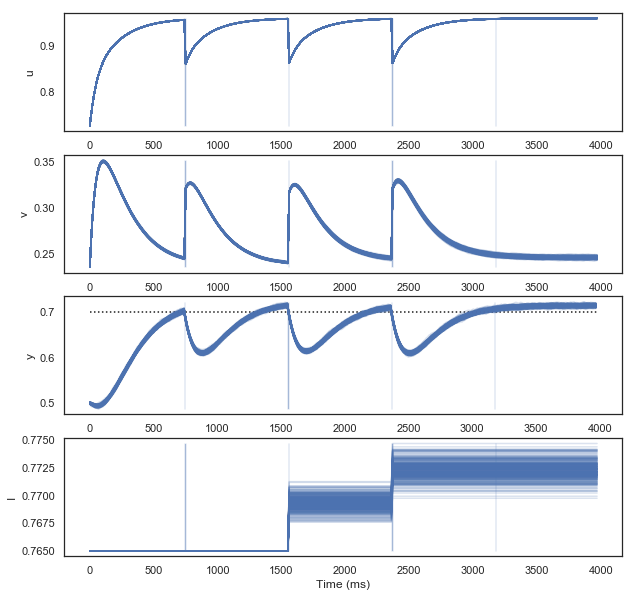

In [175]:
sigma = 0.01
K = 3.07
I = 0.765
duration = 800

#ulst, vlst, ylst, Ilst, siglst, ylst2 = simulate_trial(nstages=3, sigma=sigma, K=K, initI=0.766)
np.random.seed(2018)
ulst, vlst, ylst, Ilst, siglst, ylst2 = simulate_trial(ntrials=300, nstages=4, duration=duration, sigma=sigma, 
                                                       K=K, initI=I)
plot_simulation_parallel(ulst, vlst, ylst, Ilst, siglst, PARAMS_DICT)

Ylst2 = np.array(ylst2)
times = get_times_lst_from_y(np.array(Ylst2))
times = times[(times > 0) & (times != np.inf)]
print('Mean decision time is ', np.mean(times))

# Save the parameters in a .mat file
#scipy.io.savemat('PlotTools/uv_simulation_data012619_K3_164_I0_7825_s0_0136_1000ms.mat', {'ulst': ulst, 'vlst': vlst, 'ylst': ylst, 
#                                                  'Ilst': Ilst, 'siglst': siglst, 'PARAMS': PARAMS_DICT,
#                                                   'sigma': sigma, 'K': K, 'I': I})

## Optimizing over a single ISI

In [ ]:
#TODO: function to find I that hits the correct interval in 1 iteration..(?)

In [8]:
np.random.seed(123)
Klst = np.linspace(0, 4, 20)
sigma_lst = np.linspace(0.01, 0.1, 6)

meanlst = np.zeros((len(sigma_lst), len(Klst)))
varlst = np.zeros((len(sigma_lst), len(Klst)))

duration = 600

for i in range(len(sigma_lst)):
    for j in range(len(Klst)):
        sigma = sigma_lst[i]
        K = Klst[j]
        print('Working on K = ', K)
        ulst, vlst, ylst, Ilst, siglst, ylst2 = simulate_trial(ntrials=20000, nstages=3, 
                                                               duration=duration, sigma=sigma, K=K, initI=0.84)
        times = get_times_lst_from_y(np.array(ylst2))
        times_filt = times[(times > 0) & (times != np.inf)]
        
        if len(times_filt) < len(times):
            print('inf encountered')
            meanlst[i][j] = np.NAN
            varlst[i][j] = np.NAN
        else:
            meanlst[i][j] = np.mean(times)
            varlst[i][j] = np.std(times)

Working on K =  0.0
Working on K =  0.21052631578947367
Working on K =  0.42105263157894735
Working on K =  0.631578947368421
Working on K =  0.8421052631578947
Working on K =  1.0526315789473684
Working on K =  1.263157894736842
Working on K =  1.4736842105263157
Working on K =  1.6842105263157894
Working on K =  1.894736842105263
Working on K =  2.1052631578947367
Working on K =  2.3157894736842106
Working on K =  2.526315789473684
Working on K =  2.7368421052631575
Working on K =  2.9473684210526314
Working on K =  3.1578947368421053
Working on K =  3.3684210526315788
Working on K =  3.578947368421052
Working on K =  3.789473684210526
Working on K =  4.0
Working on K =  0.0
Working on K =  0.21052631578947367
Working on K =  0.42105263157894735
Working on K =  0.631578947368421
Working on K =  0.8421052631578947
Working on K =  1.0526315789473684
Working on K =  1.263157894736842
Working on K =  1.4736842105263157
Working on K =  1.6842105263157894
Working on K =  1.894736842105263


Text(0, 0.5, '$\\sigma$')

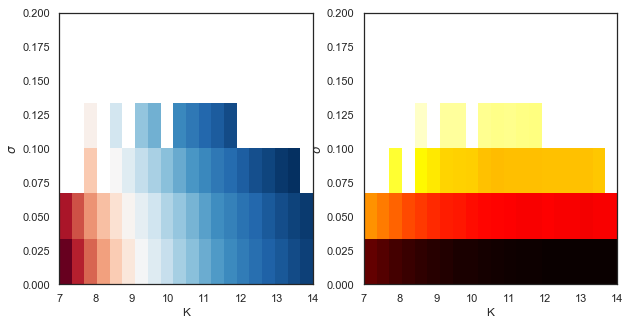

In [9]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(np.flipud((meanlst - 60)), cmap='RdBu_r', extent=[7, 14, 0, 0.2], aspect='auto')
plt.xlabel('K')
plt.ylabel(r'$\sigma$')

plt.subplot(1, 2, 2)
plt.imshow(np.flipud(varlst), extent=[7, 14, 0, 0.2], cmap='hot', aspect='auto')
plt.xlabel('K')
plt.ylabel(r'$\sigma$')

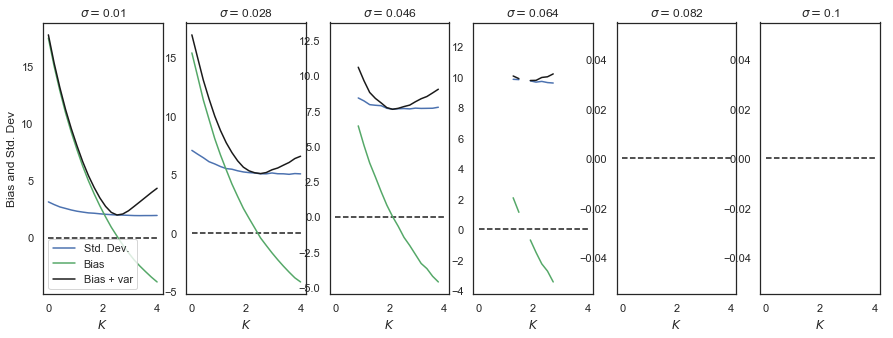

In [10]:
rmselst = np.sqrt((meanlst - 60) ** 2 + varlst**2)

fig, ax = plt.subplots(1, 6, figsize=(15, 5))
for i in range(6):
    sq_bias = (meanlst[i]-400)**2
    biasid = np.argmin(sq_bias)
    varid = np.argmin(varlst[i])
    ax[i].plot(Klst, varlst[i], color='b', label='Std. Dev.')
    ax[i].plot(Klst, meanlst[i] - 60, color='g', label='Bias')
    ax[i].plot(Klst, rmselst[i], color='k', label='Bias + var')
    #ax[i].set_ylim((-5, 10))
    ax[i].set_xlabel(r'$K$')
    ax[i].set_title(r'$\sigma=$' + str(np.round(sigma_lst[i], 3)))
    ax[i].hlines(0, min(Klst), max(Klst), linestyles='--')
    #ax[i-1].axvline(x=Klst[biasid], linestyle='--', color='g')
    #ax[i-1].axvline(x=Klst[varid], linestyle='--', color='b')

ax[0].set_ylabel('Bias and Std. Dev')
ax[0].legend(loc='lower left');
#save_safe('bias_variance_sigma_sigma.pdf')

C:\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


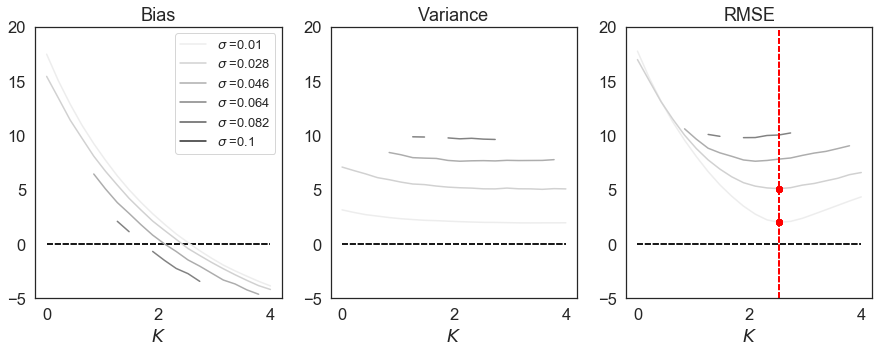

In [11]:
sns.set(font_scale=1.5)
sns.set_style('white')

colorsR = sns.color_palette('OrRd', 6)
colorsB = sns.color_palette('Blues', 6)
colorsG = sns.color_palette('Greys', 6)

rmsemins = np.min(rmselst, axis=1)
rmseargmins = np.argmin(rmselst, axis=1)

fig, ax = plt.subplots(1, 3, figsize=(15, 5))
for i in range(6):
    sq_bias = (meanlst[i]-400)**2
    biasid = np.argmin(sq_bias)
    varid = np.argmin(varlst[i])
    #ax[0].plot(Klst, varlst[i], color='b', label='Std. Dev.')
    ax[0].plot(Klst, meanlst[i] - 60, color=colorsG[i], 
               label=r'$\sigma$ =' + str(np.round(sigma_lst[i], 3)))
    #ax[0].plot(Klst, np.sqrt((meanlst[i] - 60) ** 2 + varlst[i]**2), color='k')
    ax[0].set_ylim((-5, 20))
    ax[0].set_xlabel(r'$K$')
    ax[0].set_title('Bias')
    ax[0].hlines(0, min(Klst), max(Klst), linestyles='--')
    #ax[i-1].axvline(x=Klst[biasid], linestyle='--', color='g')
    #ax[i-1].axvline(x=Klst[varid], linestyle='--', color='b')
    
for i in range(6):
    sq_bias = (meanlst[i]-400)**2
    biasid = np.argmin(sq_bias)
    varid = np.argmin(varlst[i])
    ax[1].plot(Klst, varlst[i], color=colorsG[i])
    #ax[1].plot(Klst, meanlst[i] - 60, color='g', label='Bias')
    #x[1].plot(Klst, np.sqrt((meanlst[i] - 60) ** 2 + varlst[i]**2), color='k')
    ax[1].set_ylim((-5, 20))
    ax[1].set_xlabel(r'$K$')
    ax[1].set_title('Variance')
    ax[1].hlines(0, min(Klst), max(Klst), linestyles='--')
    #ax[i-1].axvline(x=Klst[biasid], linestyle='--', color='g')
    #ax[i-1].axvline(x=Klst[varid], linestyle='--', color='b')
    
for i in range(6):
    sq_bias = (meanlst[i]-400)**2
    biasid = np.argmin(sq_bias)
    varid = np.argmin(varlst[i])
    #ax[0].plot(Klst, varlst[i], color='b', label='Std. Dev.')
    #ax[0].plot(Klst, meanlst[i] - 60, color='g', label='Bias')
    ax[2].plot(Klst, rmselst[i], color=colorsG[i])
    ax[2].set_ylim((-5, 20))
    ax[2].set_xlabel(r'$K$')
    ax[2].set_title('RMSE')
    ax[2].hlines(0, min(Klst), max(Klst), linestyles='--')
    #ax[2].plot(Klst[rmseargmins], rmsemins, '--', color=[1,0,0])
    ax[2].plot(Klst[rmseargmins], rmsemins, 'o', color=[1,0,0])
    ax[2].axvline(x=Klst[rmseargmins[0]], linestyle='--', color=[1,0,0])
    #ax[i-1].axvline(x=Klst[varid], linestyle='--', color='b')

#ax[0].set_ylabel('Bias and Std. Dev')
ax[0].legend(loc='upper right',
               prop={'size': 13});
plt.savefig('bias_variance_rmse_by_sigma.pdf')

## Optimizing over a prior

### Ready, Set, Go task

Our prior will be a discrete uniform distribution 600, 700, ..., 1000 ms.

We simulate the 1-2-Go and 1-2-3-Go tasks below and calculate the MSE landscape. $(I, K)$ will be sampled from a grid of values.

In [30]:
# Trial duration is uniformly sampled from in [600, 1000]
durations = np.linspace(600, 1000, 5)

prod_time_lst = []
prod_var_lst = []

sigma_lst = np.linspace(0.005, 0.03, 6)

nK = 10
nI = 10
Klst = np.linspace(2, 3.5, nK)
initIlst = np.linspace(0.83, 0.86, nI)
MSELST = []

for id_s, sigma in enumerate(sigma_lst):
    print('*** sigma = ', sigma, ' ***')
    mse_lst = np.zeros((nI, nK))
    for i, I in enumerate(initIlst):
        for j, K in enumerate(Klst):
            #print('I = ', I, 'K = ', K)
            mse_total = 0
            for k, dur in enumerate(durations):
                #print('Doing time #', i, '=', time)

                ulst, vlst, ylst, Ilst, siglst, ylst2 = simulate_trial(ntrials=1000, nstages=3, 
                                                                       duration=dur, sigma=sigma, K=K, initI=I)

                Ylst2 = np.array(ylst2)
                times = get_times_lst_from_y(np.array(Ylst2))
                times = times[(times > 0) & (times != np.inf)]

                mse_total += np.sum((times * 10 - time)**2)

            mse_lst[i][j] = mse_total
            print('I = ', I, 'K = ', K, 'Total MSE = ', np.sqrt(np.mean(mse_total)))
    MSELST.append(mse_lst)
    

*** sigma =  0.005  ***
I =  0.83 K =  2.0 Total MSE =  13747.465220905271
I =  0.83 K =  2.1666666666666665 Total MSE =  13247.067600038885
I =  0.83 K =  2.3333333333333335 Total MSE =  12741.153793907364
I =  0.83 K =  2.5 Total MSE =  12228.691671638468
I =  0.83 K =  2.6666666666666665 Total MSE =  11720.878806642444
I =  0.83 K =  2.833333333333333 Total MSE =  11177.338681457228
I =  0.83 K =  3.0 Total MSE =  10682.017599685933
I =  0.83 K =  3.1666666666666665 Total MSE =  10132.285033495653
I =  0.83 K =  3.333333333333333 Total MSE =  9613.396902240123
I =  0.83 K =  3.5 Total MSE =  9026.173053958139
I =  0.8333333333333333 K =  2.0 Total MSE =  12095.015502263732
I =  0.8333333333333333 K =  2.1666666666666665 Total MSE =  11680.958864750788
I =  0.8333333333333333 K =  2.3333333333333335 Total MSE =  11266.35255972402
I =  0.8333333333333333 K =  2.5 Total MSE =  10886.872829237971
I =  0.8333333333333333 K =  2.6666666666666665 Total MSE =  10439.516272318368
I =  0.8333

I =  0.8366666666666667 K =  2.1666666666666665 Total MSE =  10355.457498343567
I =  0.8366666666666667 K =  2.3333333333333335 Total MSE =  10097.375896736736
I =  0.8366666666666667 K =  2.5 Total MSE =  9837.367534050967
I =  0.8366666666666667 K =  2.6666666666666665 Total MSE =  9538.652944729669
I =  0.8366666666666667 K =  2.833333333333333 Total MSE =  9137.237000319079
I =  0.8366666666666667 K =  3.0 Total MSE =  8884.835395211327
I =  0.8366666666666667 K =  3.1666666666666665 Total MSE =  8522.44683174967
I =  0.8366666666666667 K =  3.333333333333333 Total MSE =  8257.366408244217
I =  0.8366666666666667 K =  3.5 Total MSE =  7988.316468443148
I =  0.84 K =  2.0 Total MSE =  9090.434533068263
I =  0.84 K =  2.1666666666666665 Total MSE =  8983.779828112441
I =  0.84 K =  2.3333333333333335 Total MSE =  8750.337136362234
I =  0.84 K =  2.5 Total MSE =  8570.840098846787
I =  0.84 K =  2.6666666666666665 Total MSE =  8425.354591944484
I =  0.84 K =  2.833333333333333 Total M

I =  0.8433333333333333 K =  2.5 Total MSE =  8294.40172646587
I =  0.8433333333333333 K =  2.6666666666666665 Total MSE =  8118.65136583657
I =  0.8433333333333333 K =  2.833333333333333 Total MSE =  8123.0597683385295
I =  0.8433333333333333 K =  3.0 Total MSE =  7951.69793188851
I =  0.8433333333333333 K =  3.1666666666666665 Total MSE =  7804.178368028245
I =  0.8433333333333333 K =  3.333333333333333 Total MSE =  7724.35110543274
I =  0.8433333333333333 K =  3.5 Total MSE =  7605.031229390186
I =  0.8466666666666667 K =  2.0 Total MSE =  8242.469290206667
I =  0.8466666666666667 K =  2.1666666666666665 Total MSE =  8080.67447679957
I =  0.8466666666666667 K =  2.3333333333333335 Total MSE =  7872.909246269767
I =  0.8466666666666667 K =  2.5 Total MSE =  7702.356782180374
I =  0.8466666666666667 K =  2.6666666666666665 Total MSE =  7566.696769396802
I =  0.8466666666666667 K =  2.833333333333333 Total MSE =  7446.07950535045
I =  0.8466666666666667 K =  3.0 Total MSE =  7236.71886

I =  0.85 K =  2.6666666666666665 Total MSE =  8123.786063160453
I =  0.85 K =  2.833333333333333 Total MSE =  8091.853928488823
I =  0.85 K =  3.0 Total MSE =  7881.992133972223
I =  0.85 K =  3.1666666666666665 Total MSE =  8013.800596471066
I =  0.85 K =  3.333333333333333 Total MSE =  7949.521998208445
I =  0.85 K =  3.5 Total MSE =  7904.6189028946865
I =  0.8533333333333333 K =  2.0 Total MSE =  11161.482876392365
I =  0.8533333333333333 K =  2.1666666666666665 Total MSE =  10204.293214132962
I =  0.8533333333333333 K =  2.3333333333333335 Total MSE =  9421.735508917664
I =  0.8533333333333333 K =  2.5 Total MSE =  8766.019621242014
I =  0.8533333333333333 K =  2.6666666666666665 Total MSE =  8407.068454580349
I =  0.8533333333333333 K =  2.833333333333333 Total MSE =  8208.501690320834
I =  0.8533333333333333 K =  3.0 Total MSE =  7951.572171589716
I =  0.8533333333333333 K =  3.1666666666666665 Total MSE =  7736.34926822723
I =  0.8533333333333333 K =  3.333333333333333 Total M

I =  0.8566666666666667 K =  2.833333333333333 Total MSE =  9324.355205589285
I =  0.8566666666666667 K =  3.0 Total MSE =  9110.0
I =  0.8566666666666667 K =  3.1666666666666665 Total MSE =  8673.148217342996
I =  0.8566666666666667 K =  3.333333333333333 Total MSE =  8608.925600793633
I =  0.8566666666666667 K =  3.5 Total MSE =  8683.357645519387
I =  0.86 K =  2.0 Total MSE =  16654.720051685046
I =  0.86 K =  2.1666666666666665 Total MSE =  14851.680039645347
I =  0.86 K =  2.3333333333333335 Total MSE =  13150.813663040017
I =  0.86 K =  2.5 Total MSE =  11848.096893594346
I =  0.86 K =  2.6666666666666665 Total MSE =  10394.233978509432
I =  0.86 K =  2.833333333333333 Total MSE =  9815.533607501937
I =  0.86 K =  3.0 Total MSE =  9287.911498286361
I =  0.86 K =  3.1666666666666665 Total MSE =  8848.06758563699
I =  0.86 K =  3.333333333333333 Total MSE =  8532.637341408576
I =  0.86 K =  3.5 Total MSE =  8568.774708206536
*** sigma =  0.03  ***
I =  0.83 K =  2.0 Total MSE =  1

In [153]:
scipy.io.savemat('PlotTools/IK_relationship_sigma_0-02_102918_1000trials.mat', {'MSELST': MSELST,
                                                          'Klst': Klst,
                                                          'Ilst': initIlst})

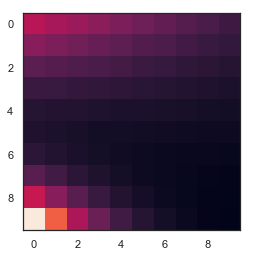

In [33]:
plt.imshow(MSELST[1])

Instead of sampling from a grid of $(I, K)$, here we do a random sampling of $(I, K)$.

In [176]:
import time

### Doing random sampling for (I,K)

# Initiate the trial with a fixed current, trial duration is randomized in [600, 1000]
durations = np.linspace(600, 1000, 5)

prod_time_lst = []
prod_var_lst = []

sigma_lst = np.linspace(0.005, 0.06, 10)

nsamples = 100
nstages = 8
MSELST = []

maxiter = 3
ILST = np.zeros((len(sigma_lst), maxiter))
KLST = np.zeros((len(sigma_lst), maxiter))

#Klst = np.linspace(0.5, 3.5, nsamples)

#bar = Bar('Processing', max=1000)
#bar.start()

start = time.time()

# Do simulation several times to obtain error bars
for id_s, sigma in enumerate(sigma_lst):
    print('*** sigma = ', sigma, ' ***')
    for niter in range(maxiter):
        print('    Running iteration #', niter)
        # For each iteration, re-pick list of I and K
        Klst = np.random.uniform(low=1, high=3.5, size=nsamples)
        initIlst = np.random.uniform(low=0.75, high=0.78, size=nsamples)
    
        mse_lst = np.zeros(nsamples)
        for i in range(nsamples):
            I = initIlst[i]
            K = Klst[i]
            mse_total = 0
            #print('        Doing time I = %f. K = %f' % (I, K))
            for k, dur in enumerate(durations):
                #print('        Doing time #%d = %f. I = %f. K = %f\n' % (k, time, I, K))

                ulst, vlst, ylst, Ilst, siglst, ylst2 = simulate_trial(ntrials=100, nstages=nstages, 
                                                                       duration=dur, sigma=sigma, K=K, initI=I)

                Ylst2 = np.array(ylst2)
                times = get_times_lst_from_y(np.array(Ylst2))
                times = times[(times > 0) & (times != np.inf)]

                mse_total += np.sum((times * 10 - dur)**2)

            mse_lst[i] = np.sqrt(np.mean(mse_total))
            #print('I = ', I, 'K = ', K, 'Total MSE = ', np.sqrt(np.mean(mse_total)))
            #bar.next()
        # Determine the arg-min of the list
        argmin = np.argsort(mse_lst)
        Kmin = Klst[argmin[0]]
        Imin = initIlst[argmin[0]]
        KLST[id_s][niter] = Kmin
        ILST[id_s][niter] = Imin
        print('        Kmin = ', Kmin, ', Imin =', Imin)

end = time.time()
print('Time taken = ', end - start)
# Save simulation results
#scipy.io.savemat('PlotTools/IK_optimization_data_I_0_78_1000trials.mat', {'initIlst': initIlst, 'Klst': Klst, 'KLST': KLST, 
#                                                  'ILST': ILST, 'sigma_lst': sigma_lst, 'PARAMS': PARAMS_DICT})
        
#bar.finish()
    
#plt.plot(initIlst, mse_lst)

*** sigma =  0.005  ***
    Running iteration # 0
        Kmin =  3.2736723119140403 , Imin = 0.7771364443483809
    Running iteration # 1
        Kmin =  2.392833471608541 , Imin = 0.779219651209259
    Running iteration # 2
        Kmin =  3.3851272956396143 , Imin = 0.7775872651191978
*** sigma =  0.011111111111111112  ***
    Running iteration # 0
        Kmin =  1.9879531004073598 , Imin = 0.7798075875957434
    Running iteration # 1
        Kmin =  2.26445435795722 , Imin = 0.7766449844144084
    Running iteration # 2
        Kmin =  2.611886987418726 , Imin = 0.7799614794497467
*** sigma =  0.017222222222222222  ***
    Running iteration # 0
        Kmin =  3.353959897625855 , Imin = 0.7698532395839949
    Running iteration # 1
        Kmin =  3.097362977781086 , Imin = 0.7774748890561275
    Running iteration # 2
        Kmin =  2.1962845810365645 , Imin = 0.7781481899296402
*** sigma =  0.023333333333333334  ***
    Running iteration # 0
        Kmin =  2.074449211852535 , Imi

Plotting the result of the simulation of optimized $(I, K)$ together with the fitted values.

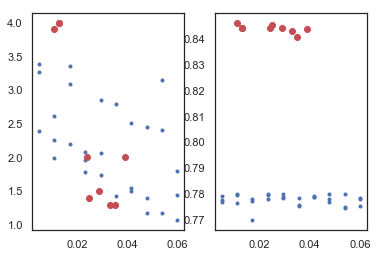

In [177]:
# Behavioral results
#sigma_behavior = [0.019, 0.019, 0.008, 0.02, 0.009, 0.01, 0.017, 0.0245, 0.026];
#I_behavior = [0.780, 0.779, 0.783, 0.780, 0.783, 0.782, 0.7805, 0.7792, 0.7773];
#K_behavior = [1.0, 1.0, 2.7, 1.0, 3.3, 2.7, 0.8, 0.8, 0.85];

# Params fit with threshold = 0.7
#sigma_behavior = [0.009, 0.018, 0.023, 0.007, 0.021, 0.009, 0.020, 0.025, 0.027];
#I_behavior = [0.781, 0.780, 0.780, 0.782, 0.781, 0.782, 0.781, 0.779, 0.777];
#K_behavior = [2.55, 1.10, 1.28, 2.76, 1.65, 2.89, 0.78, 0.67, 0.75];


# Params fit with threshold = 0.6
#sigma_behavior = [0.015, 0.026, 0.032, 0.012, 0.030, 0.013, 0.025, 0.035, 0.036];
#I_behavior = [0.848, 0.845, 0.844, 0.849, 0.845, 0.847, 0.845, 0.844, 0.841];
#K_behavior = [2.6, 1.0, 1.0, 2.7, 0.9, 2.7, 0.7, 0.7, 0.7];

# Fit with new model (with initial stage constant time)
sigma_behavior = [0.013, 0.024, 0.039, 0.011, 0.029, 0.013, 0.025, 0.033, 0.035];
I_behavior = [0.844, 0.844, 0.8435, 0.846, 0.844, 0.844, 0.845, 0.843, 0.8405];
K_behavior = [4.0, 2.0, 2.0, 3.9, 1.5, 4.0, 1.4, 1.3, 1.3];

plt.subplot(121)

for i, sigma in enumerate(sigma_lst):
    plt.plot(np.ones(maxiter) * sigma, KLST[i,:],'b.')
    
plt.plot(sigma_behavior, K_behavior, 'or')


plt.subplot('122')
plt.plot(sigma_behavior, I_behavior, 'or')

for i, sigma in enumerate(sigma_lst):
    plt.plot(np.ones(maxiter) * sigma, ILST[i,:],'b.')
    


In [200]:
scipy.io.savemat('PlotTools/IK_sim_relationship.mat', {'ILST': ILST, 'KLST': KLST,
                                            'sigma_lst': sigma_lst})

In [40]:
def find_min_indices(mat):
    '''Given a matrix, return the indices i, j such that mat[i][j] is the minimum entry'''
    idmin = np.argmin(mat)
    m, n = mat.shape
    
    return idmin // n, idmin % n

def find_min_IK(mat, Ivals, Kvals):
    '''Given the MSE matrix, find the I and K corresponding to the min MSE'''
    i, j = find_min_indices(mat)
    
    if i == 0 or i == len(Ivals) - 1:
        print('Warning: minimum at boundary for I')
    
    if j == 0 or j == len(Kvals) - 1:
        print('Warning: minimum at boundary for K')
    
    return Ivals[i], Kvals[j]
    



In [41]:
# (Old) Finding min (I, K) in a grid
Isim = []
Ksim = []
for id in range(12):
    I,K = find_min_IK(MSELST[id], initIlst, Klst)
    Isim.append(I)
    Ksim.append(K)
    print(I, K)

IndexError: list index out of range

In [ ]:
plt.figure(figsize=(5, 5))
plt.imshow(np.flipud(np.log(mse_lst)), cmap='hot', aspect='auto',
           extent=[np.min(Klst), np.max(Klst), np.min(initIlst), np.max(initIlst)])
plt.xlabel(r'$K$')
plt.ylabel(r'$I_{init}$')
plt.colorbar(label='log MSE')
plt.savefig('SWE_KI_optimization.pdf')

In [ ]:
#KI optimization for subject SWE in RSSG, sigma = 0.01 (found by fitting sd of responses)
# Pick a trial duration from [400, 600], and find the MSE across the different trial durations

# Initiate the trial with a fixed current, trial duration is randomized in [400, 600]
durations = np.linspace(600, 1000, 11)

prod_time_lst = []
prod_var_lst = []

mse_lst = np.zeros((11, 11))
Klst = np.linspace(2.5, 3.5, 11)
initIlst = np.linspace(0.775, 0.785, 11)

for i, I in enumerate(initIlst):
    for j, K in enumerate(Klst):
        #print('I = ', I, 'K = ', K)
        mse_total = 0
        for k, time in enumerate(durations):
            #print('Doing time #', i, '=', time)

            ulst, vlst, ylst, Ilst, siglst, ylst2 = simulate_trial(ntrials=1000, nstages=4, 
                                                                   duration=time, sigma=0.01, K=K, initI=I)

            Ylst2 = np.array(ylst2)
            times = get_times_lst_from_y(np.array(Ylst2), 0.7)
            times = times[(times > 0) & (times != np.inf)]

            mse_total += np.sum((times * 10 - time)**2)

        mse_lst[i][j] = mse_total
        print('I = ', I, 'K = ', K, 'Total MSE = ', mse_total)
    
plt.plot(initIlst, mse_lst)

In [ ]:
# Initiate the trial with a fixed current, trial duration is randomized in [400, 600]
durations = np.linspace(500, 700, 11)

prod_time_lst = []
prod_var_lst = []

for i, time in enumerate(durations):
    print('Doing time #', i, '=', time)
    
    ulst, vlst, ylst, Ilst, siglst, ylst2 = simulate_trial(ntrials=1000, nstages=3, 
                                                           duration=time, sigma=0.01, K=1.8, initI=0.77)

    Ylst2 = np.array(ylst2)
    times = get_times_lst_from_y(np.array(Ylst2), 0.7)
    times = times[(times > 0) & (times != np.inf)]
    #print('Mean level at decision time is ', np.mean(Ylst2[60,:]))
    #print('Mean decision time is ', np.mean(times))
    prod_time_lst.append(np.mean(times))
    prod_var_lst.append(np.std(times))
    
# Plot the result, error bars represent standard deviation
plt.plot(durations, durations, '--')
plt.errorbar(durations, np.array(prod_time_lst) * 10, np.array(prod_var_lst) * 10)
plt.xlabel('$t_S$')
plt.ylabel('$t_P$')
plt.title('Production times in RSG simulation')

Doing time # 0 = [600]
Doing time # 1 = [700]
Doing time # 2 = [800]
Doing time # 3 = [900]
Doing time # 4 = [1000]
Doing time # 0 = [600]
Doing time # 1 = [700]
Doing time # 2 = [800]
Doing time # 3 = [900]
Doing time # 4 = [1000]
RSG results:
Observed mean STD =  60.067726665412124
Simulated mean STD =  87.48958338808484
RSSG results:
Observed mean STD =  62.409422380986214
Simulated mean STD =  90.2646754910041


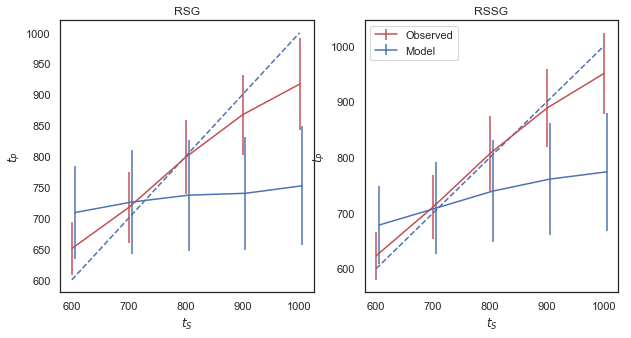

In [160]:
# Load data for subject GB (RSG/RSSG, Seth provided)
subject_file = 'SWE_EKF_ObsAct0_20171105.mat'

sigma_val = 0.035
I_val = 0.8405
K_val = 1.3

subject_data = scipy.io.loadmat(subject_file)
B = subject_data['B']
ts_vec = subject_data['ts_vec']
ta = subject_data['ta']
tss = subject_data['tss']
mtp_in = subject_data['mtp_in']
stdtp_in = subject_data['stdtp_in']

b = np.mean(B[:,0])

# Initiate the trial with a fixed current, trial duration is randomized in [400, 600]
durations = tss

prod_time_lst = []
prod_var_lst = []
prod_time_lst2 = []
prod_var_lst2 = []

#1,2,Go simulation
for i, time in enumerate(durations):
    print('Doing time #', i, '=', time)
    
    ulst, vlst, ylst, Ilst, siglst, ylst2 = simulate_trial(ntrials=1000, nstages=3, duration=time, 
                                                           sigma=sigma_val, K=K_val, initI=I_val)

    Ylst2 = np.array(ylst2)
    times = get_times_lst_from_y(np.array(Ylst2))
    times = times[(times > 0) & (times != np.inf)]
    #print('Mean level at decision time is ', np.mean(Ylst2[60,:]))
    #print('Mean decision time is ', np.mean(times))
    prod_time_lst.append(np.mean(times))
    prod_var_lst.append(np.std(times))

#1,2,3,Go simulation
for i, time in enumerate(durations):
    print('Doing time #', i, '=', time)
    
    ulst, vlst, ylst, Ilst, siglst, ylst2 = simulate_trial(ntrials=1000, nstages=4, duration=time, 
                                                           sigma=sigma_val, K=K_val, initI=I_val)

    Ylst2 = np.array(ylst2)
    times = get_times_lst_from_y(np.array(Ylst2))
    times = times[(times > 0) & (times != np.inf)]
    #print('Mean level at decision time is ', np.mean(Ylst2[60,:]))
    #print('Mean decision time is ', np.mean(times))
    prod_time_lst2.append(np.mean(times))
    prod_var_lst2.append(np.std(times))
    
# Plot the result, error bars represent standard deviation
plt.figure(figsize=(10, 5))
plt.subplot('121')
plt.errorbar(tss, mtp_in[:,0], stdtp_in[:,0], color='r', label='Observed')
#plt.errorbar(tss, mtp_in[:,1], stdtp_in[:,1], color='g')

# Plot the result, error bars represent standard deviation
plt.plot(durations, durations, '--')
plt.errorbar(durations + 5, np.array(prod_time_lst) * 10, np.array(prod_var_lst) * 10, color='b', label='Model')
plt.xlabel('$t_S$')
plt.ylabel('$t_P$')
plt.title('RSG')

plt.subplot('122')
plt.errorbar(tss, mtp_in[:,1], stdtp_in[:,1], color='r', label='Observed')
#plt.errorbar(tss, mtp_in[:,1], stdtp_in[:,1], color='g')

# Plot the result, error bars represent standard deviation
plt.plot(durations, durations, '--')
plt.errorbar(durations + 5, np.array(prod_time_lst2) * 10, np.array(prod_var_lst2) * 10, color='b', label='Model')
plt.xlabel('$t_S$')
plt.ylabel('$t_P$')
plt.title('RSSG')
plt.legend()

print('RSG results:')
print('Observed mean STD = ', np.mean(stdtp_in[:,0]))
print('Simulated mean STD = ', np.mean(np.mean(prod_var_lst)* 10))

print('RSSG results:')
print('Observed mean STD = ', np.mean(stdtp_in[:,1]))
print('Simulated mean STD = ', np.mean(np.mean(prod_var_lst2)* 10))

In [ ]:
# Load data for subject SWE(RSG/RSSG, Seth provided)
swedata = scipy.io.loadmat('
                           
                           
                           ')
B = swedata['B']
ts_vec = swedata['ts_vec']
ta = swedata['ta']
tss = swedata['tss']
mtp_in = swedata['mtp_in']
stdtp_in = swedata['stdtp_in']

b = np.mean(B[:,0])



# Initiate the trial with a fixed current, trial duration is randomized in [400, 600]
durations = tss

prod_time_lst = []
prod_var_lst = []
prod_time_lst2 = []
prod_var_lst2 = []


#1,2,Go simulation
for i, time in enumerate(durations):
    print('Doing time #', i, '=', time)
    
    ulst, vlst, ylst, Ilst, siglst, ylst2 = simulate_trial(ntrials=1000, nstages=3, duration=time, sigma=0.01, K=3, initI=0.782)

    Ylst2 = np.array(ylst2)
    times = get_times_lst_from_y(np.array(Ylst2), 0.7)
    times = times[(times > 0) & (times != np.inf)]
    #print('Mean level at decision time is ', np.mean(Ylst2[60,:]))
    #print('Mean decision time is ', np.mean(times))
    prod_time_lst.append(np.mean(times))
    prod_var_lst.append(np.std(times))

#1,2,3,Go simulation
for i, time in enumerate(durations):
    print('Doing time #', i, '=', time)
    
    ulst, vlst, ylst, Ilst, siglst, ylst2 = simulate_trial(ntrials=1000, nstages=4, duration=time, sigma=0.01, K=2.9, initI=0.7818)

    Ylst2 = np.array(ylst2)
    times = get_times_lst_from_y(np.array(Ylst2), 0.7)
    times = times[(times > 0) & (times != np.inf)]
    #print('Mean level at decision time is ', np.mean(Ylst2[60,:]))
    #print('Mean decision time is ', np.mean(times))
    prod_time_lst2.append(np.mean(times))
    prod_var_lst2.append(np.std(times))
    
# Plot the result, error bars represent standard deviation
plt.figure(figsize=(10, 5))
plt.subplot('121')
plt.errorbar(tss, mtp_in[:,0], stdtp_in[:,0], color='r', label='Observed')
#plt.errorbar(tss, mtp_in[:,1], stdtp_in[:,1], color='g')

# Plot the result, error bars represent standard deviation
plt.plot(durations, durations, '--')
plt.errorbar(durations + 5, np.array(prod_time_lst) * 10, np.array(prod_var_lst) * 10, color='b', label='Model')
plt.xlabel('$t_S$')
plt.ylabel('$t_P$')
plt.title('RSG')

plt.subplot('122')
plt.errorbar(tss, mtp_in[:,1], stdtp_in[:,1], color='r', label='Observed')
#plt.errorbar(tss, mtp_in[:,1], stdtp_in[:,1], color='g')

# Plot the result, error bars represent standard deviation
plt.plot(durations, durations, '--')
plt.errorbar(durations + 5, np.array(prod_time_lst2) * 10, np.array(prod_var_lst2) * 10, color='b', label='Model')
plt.xlabel('$t_S$')
plt.ylabel('$t_P$')
plt.title('RSSG')
plt.legend()

In [153]:
# Fitting the data to find sigma

# Load data for subject SWE(RSG/RSSG, Seth provided)
swedata = scipy.io.loadmat('SWE_EKF_ObsAct0_20171125.mat')
B = swedata['B']
ts_vec = swedata['ts_vec']
ta = swedata['ta']
tss = swedata['tss']
mtp_in = swedata['mtp_in']
stdtp_in = swedata['stdtp_in']

b = np.mean(B[:,0])

# Initiate the trial with a fixed current, trial duration is randomized in [400, 600]
durations = tss

prod_time_lst = []
prod_var_lst = []
prod_time_lst2 = []
prod_var_lst2 = []


#1,2,Go simulation
for i, time in enumerate(durations):
    print('Doing time #', i, '=', time)
    
    ulst, vlst, ylst, Ilst, siglst, ylst2 = simulate_trial(ntrials=10000, nstages=3, duration=time, sigma=0.017, K=1, initI=0.844)

    Ylst2 = np.array(ylst2)
    times = get_times_lst_from_y(np.array(Ylst2))
    times = times[(times > 0) & (times != np.inf)]
    #print('Mean level at decision time is ', np.mean(Ylst2[60,:]))
    #print('Mean decision time is ', np.mean(times))
    prod_time_lst.append(np.mean(times))
    prod_var_lst.append(np.std(times))
    
#1,2,3,Go simulation
for i, time in enumerate(durations):
    print('Doing time #', i, '=', time)
    
    ulst, vlst, ylst, Ilst, siglst, ylst2 = simulate_trial(ntrials=10000, nstages=4, duration=time, sigma=0.017, K=1, initI=0.844)

    Ylst2 = np.array(ylst2)
    times = get_times_lst_from_y(np.array(Ylst2))
    times = times[(times > 0) & (times != np.inf)]
    #print('Mean level at decision time is ', np.mean(Ylst2[60,:]))
    #print('Mean decision time is ', np.mean(times))
    prod_time_lst2.append(np.mean(times))
    prod_var_lst2.append(np.std(times))

print('RSG results:')
print('Observed mean STD = ', np.mean(stdtp_in[:,0]))
print('Simulated mean STD = ', np.mean(np.mean(prod_var_lst)* 10))

print('RSSG results:')
print('Observed mean STD = ', np.mean(stdtp_in[:,1]))
print('Simulated mean STD = ', np.mean(np.mean(prod_var_lst2)* 10))

Doing time # 0 = [600]
Doing time # 1 = [700]
Doing time # 2 = [800]
Doing time # 3 = [900]
Doing time # 4 = [1000]
Doing time # 0 = [600]
Doing time # 1 = [700]
Doing time # 2 = [800]
Doing time # 3 = [900]
Doing time # 4 = [1000]
RSG results:
Observed mean STD =  60.067726665412124
Simulated mean STD =  61.04119540077397
RSSG results:
Observed mean STD =  62.55656483944044
Simulated mean STD =  60.63643865294171
